<h3>3D Data Pipeline</h3>


1. Load the h5 files and save the data if possible insimilar objects like Adam did
2. Registration of the Images to a 3D Volume
3. Save to a .nil
4. Interactive Scatterplots for better fitting

In [15]:
%matplotlib ipympl

import h5py
import os
import glob
import sys
import cv2

import numpy as np
import nibabel as nib
from skimage.filters import gaussian as gaussian_filter_skimage 

sys.path.append(r'/zhome/a7/7/183900/Thesis/CellTracking/DataAnalysis/Classes')
sys.path.append(r'/zhome/a7/7/183900/Thesis/CellTracking/PMP')


from ImageSliceData import ImageSliceData
from ImageVolumeData import ImageVolumeData
from util_2D import *

In [8]:
#Register the volume => might more easier for some strain than for others, with time do we first register the slices and than the volumes over time ?
def determine_warp_matrix(reference_image, moving_image, mask):
    # Apply Gaussian filter to smooth both images, in ECC we already have this on default but double will not hurt any
    moving_gaussian = gaussian_filter_skimage(moving_image, sigma=5)
    
    reference_norm_image = reference_image.astype(np.float32)
    moving_norm_image = moving_gaussian.astype(np.float32)

    # Initialize the warp matrix for rigid (Euclidean) transformation
    warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Define criteria for ECC
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-6)

    # Perform ECC registration using the norm images, findTransformECC already has a gaussian filter on default gaussFiltSize=5
    try:
        cc, warp_matrix = cv2.findTransformECC(reference_norm_image, moving_norm_image, warp_matrix, cv2.MOTION_TRANSLATION, criteria, inputMask=mask)
    except cv2.error as e:
        print(f"ECC registration failed: {e}")
        return moving_image  # Return original image if registration fails



    return warp_matrix

def move_image(reference_image, moving_image,warp_matrix):
    aligned_image = cv2.warpAffine(moving_image, warp_matrix, (reference_image.shape[1], reference_image.shape[0]),
                                   flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return aligned_image

def register_volume(volume_chi, volume_phi):
    reference_index = int(len(volume_chi)/2)
    reference_image = volume_chi[reference_index]  # Use the 2D image at index 4 as the reference
    print(reference_image.shape)
    #create mask => this is quite manuel still
    mask = np.zeros_like(reference_image, dtype=np.uint8)
    mask[300:1500, 700:1500] = 1

    # Align each 2D image in 'cropped_chi' to the reference
    aligned_images_chi,aligned_images_phi = [],[]
    for i in range(len(volume_chi)):
        if i == reference_index-1:
            aligned_images_chi.append(reference_image)  # Append the reference image itself
            aligned_images_phi.append(volume_phi[reference_index])
            continue

        warp_matrix = determine_warp_matrix(reference_image, volume_chi[i],mask)

        aligned_image_chi = move_image(reference_image, volume_chi[i],warp_matrix)
        aligned_image_phi = move_image(reference_image, volume_phi[i],warp_matrix)
        aligned_images_chi.append(aligned_image_chi)
        aligned_images_phi.append(aligned_image_phi)

    # Convert the list of aligned images into a NumPy array
    aligned_images_array_chi = np.array(aligned_images_chi)
    aligned_images_array_phi = np.array(aligned_images_phi)

    return aligned_images_array_chi,aligned_images_array_phi

In [9]:
dir = r"/dtu/3d-imaging-center/projects/2022_QIM_PMP/analysis/Johann_Haack"
h5_files = glob.glob(os.path.join(dir, "*.h5"))
#sort the files
dict_of_image_slices_by_volume = {}

for file_name in h5_files:
    key = file_name.split("pct")[0].split('cells')[1].split('_',1)[1]
    if key not in dict_of_image_slices_by_volume.keys():
        dict_of_image_slices_by_volume[key] = []
    else:
        dict_of_image_slices_by_volume[key].append(file_name)
list_image_volumes = []
list_volume = []
for key,values in dict_of_image_slices_by_volume.items():
    if key != "2_6-5":
        continue
    for val in values:
        path = os.path.join(dir, val)
        img_data = ImageSliceData()
        img_data.set_h5_file(path)
        img_data.extract_data()
        list_volume.append(img_data)
    list_image_volumes.append(ImageVolumeData(list_volume))
    break

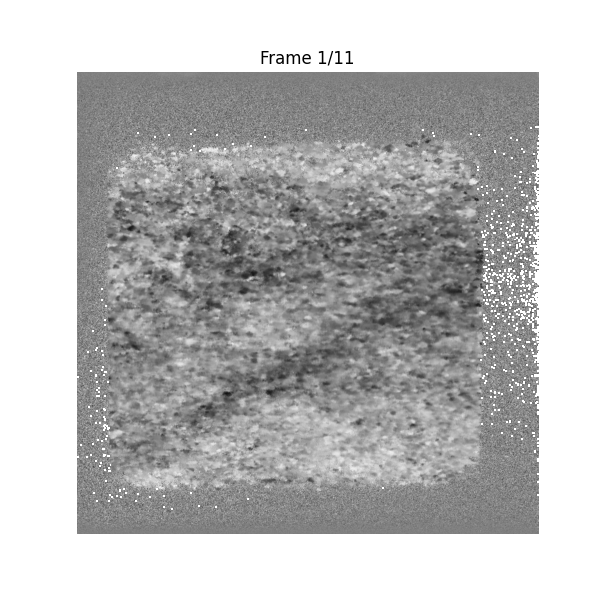

In [17]:
volume = list_image_volumes[0]
chi_com_array =delete volume.chi_com_array
film_2D(volume.chi_com_array)
volum

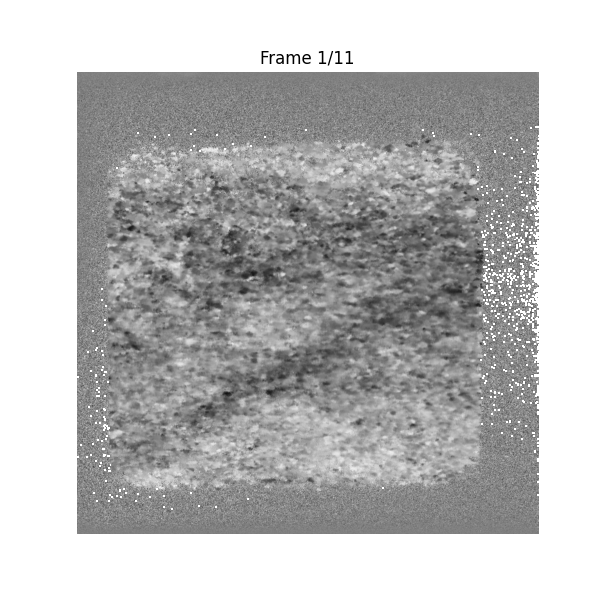

(2048, 2048)
ECC registration failed: OpenCV(4.6.0) /io/opencv/modules/video/src/ecc.cpp:574: error: (-7:Iterations do not converge) NaN encountered. in function 'findTransformECC'



error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/imgwarp.cpp:2604: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'warpAffine'


In [16]:
#lets register one and plot it
com_volume_registered_chi,_ = register_volume(volume.chi_com_array,volume.phi_com_array)

In [7]:
#Save as nii.gz to look at in itksnap
list_nii_volumes = []
for volume in list_image_volumes:
    list_np_slices = []
    for slice in volume:
        list_np_slices.append(slice.numpy_feature_array)
    list_nii_volumes.append(nib.Nifti1Image(np.transpose(list_np_slices,(1,0,2,3)), np.eye(4)))

nib.save(list_nii_volumes[0], os.path.join(dir, "2_6-5.nii.gz"))

TypeError: 'ImageVolumeData' object is not iterable